# I - Embedding : Word 2 Vec

### I.1 - Import data

In [1]:
import json

with open('yelp_reviews_part1.json') as json_file:
    reviews = json.load(json_file)

print("File imported ({} reviews)".format(len(reviews)))

File imported (14075 reviews)


### I.2 - Prepare data

In [2]:
### import libraries and define helpful functions

import re

def cleaning(text) : 
    """ 
    Few operations to clean a text.
    """
    chars_ = "'*"
    chars = "()"

    t = text.lower().replace("\n", " ").replace("\"", "")
    for c in chars_ : 
        t = t.replace(c, " ")
    for c in chars : 
        t = t.replace(c, "")

    t = " ".join([w for w in t.split(" ") if not w==""])
    
    return t

In [3]:
### Clean texts from every reviews and gather them

keys = list(reviews.keys())

texts = []
for k in keys : 
    try : 
        text = reviews[k]['text']
        t = cleaning(text)
        texts.append(t)
    except : None

TEXT = " ".join(texts)

del reviews # free memory

# verbose
print("Texts cleaned and gathered : \n    '" + TEXT[:500] + "...'")

Texts cleaned and gathered : 
    'as someone who has worked with many museums, i was eager to visit this gallery on my most recent trip to las vegas. when i saw they would be showing infamous eggs of the house of faberge from the virginia museum of fine arts vmfa, i knew i had to go! tucked away near the gelateria and the garden, the gallery is pretty much hidden from view. it s what real estate agents would call cozy or charming - basically any euphemism for small. that being said, you can still see wonderful art at a gallery o...'


In [4]:
### Count words occurences and select 

occ = 20 # Minimal number of occurences for a word to be kept

# create words list
Words = re.findall(r"[\w']+", TEXT)
WordsSet = list(set(Words))
N = len(WordsSet)

# verbose
print(str(N) + " unique words.") 
print("Let's count occurences and select only those who appears at least " + str(occ) + " times : ")

# Count
WordsCount = {}
for i, w in enumerate(WordsSet) : 
    c = Words.count(w)
    if c >= occ : # We keep words occuring at least "occ" times
        WordsCount[w] = c
    if (i+1)%2500 == 0 : print("    words done : " + str(i+1) + " (" + str(round(100*(i+1)/N)) + "%)")

numWords = len(WordsCount)
        
# verbose
print("We now have {} unique words".format(numWords))

# Store file
with open('wordscount.json', 'w', encoding='utf-8') as f:
    json.dump(WordsCount, f, ensure_ascii=False, indent=4)   
print("File stored.")

30770 unique words.
Let's count occurences and select only those who appears at least 20 times : 
    words done : 2500 (8%)
    words done : 5000 (16%)
    words done : 7500 (24%)
    words done : 10000 (32%)
    words done : 12500 (41%)
    words done : 15000 (49%)
    words done : 17500 (57%)
    words done : 20000 (65%)
    words done : 22500 (73%)
    words done : 25000 (81%)
    words done : 27500 (89%)
    words done : 30000 (97%)
We now have 4124 unique words
File stored.


In [5]:
### replace word by number 

WordsDict = {i:w for i, w in enumerate(list(WordsCount.keys()))}
WordsDictReverse = {v:k for k, v in WordsDict.items()}
Words = list(WordsCount.keys())

del WordsCount # free memory

# Store file
with open('wordsDict.json', 'w', encoding='utf-8') as f:
    json.dump(WordsDict, f, ensure_ascii=False, indent=4)   

### I.3 - W2V

In [6]:
### import libraries and define helpful functions

import json
import random
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn

def onehot(lst, N) : 
    """
    Compute one hot version of the input regarding a given size.
    """
    return [1*(i in lst) for i in range(N)]

def getData(batch) : 
    """
    From a batch, create well formated training elements.
    """
    X = [t[0] for t in batch]
    X_onehot = [onehot(x, N=numWords) for x in X]
    X = torch.FloatTensor(X_onehot)
    
    Y = [t[1] for t in batch]
    Y = torch.tensor(Y).reshape(-1)
    
    return X, Y   

def getLoss(X, Y) :
    """
    Compute loss.
    """
    pred = model.forward(X)
    output = loss(pred, Y)
    return output

def createBatches(dataSet, batch_size):
    """
    Create batches regarding a given data set and a given batch size.
    """
    batches = []
    j=0
    while len(dataSet) >  0: 
        batch = dataSet[:min(batch_size, len(dataSet)-1)]
        dataSet = dataSet[min(batch_size, len(dataSet)-1):]
        j += batch_size
        
        X, Y = getData(batch)
        
        batches.append([X, Y])
        
    return batches

class MyW2V(nn.Module):
    def __init__(self, num_words, hidden_size):
        super(MyW2V, self).__init__()
        
        self.linear1 = nn.Linear(num_words, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_words)
                
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x


In [7]:
### Create Training set (CBOW style)

windowRay = 4 # ray of window for the CBOW implementation

phrases = re.split(r' *[\.\?!][\'"\)\]]* *', TEXT)

trainingSet = {}
k = 0

# verbose
print("Creating training set (with window size of {})...".format(2*windowRay+1))
print(str(len(phrases)) + " phrases.")

for i, phrase in enumerate(phrases) : 
    
    # verbose
    if (i+1)%10000==0 : print("    phrases processed : " + str(i+1) + " ("+ str(round((i+1)/len(phrases)*100)) + "%)")
    
    # compute words list and clean them
    words = re.findall(r"[\w']+", phrase)
    words = [w.lower().replace("'", " ") for w in words]

    for j in range(len(words)):
        y = words[j]
        if y in Words : 
            m = max(j-windowRay, 0) # window min
            M = min(j+windowRay+1, len(words)-1) # window max

            x = words[m:j] + words[(j+1):M] 

            yn = WordsDictReverse[y]
            xn = [WordsDictReverse[w] for w in x if w in Words] 
        
        if len(xn) > 0 : trainingSet[k] = [xn, yn]
        k += 1

# Store TrainingSet
with open('trainingset.json', 'w', encoding='utf-8') as f:
    json.dump(trainingSet, f, ensure_ascii=False, indent=4)   

del TEXT # Free Memory

numWords = max([train[1] for train in list(trainingSet.values())]) + 1

# verbose
print("Done. Set size : {} elements".format(len(trainingSet)))

Creating training set (with window size of 9)...
129051 phrases.
    phrases processed : 10000 (8%)
    phrases processed : 20000 (15%)
    phrases processed : 30000 (23%)
    phrases processed : 40000 (31%)
    phrases processed : 50000 (39%)
    phrases processed : 60000 (46%)
    phrases processed : 70000 (54%)
    phrases processed : 80000 (62%)
    phrases processed : 90000 (70%)
    phrases processed : 100000 (77%)
    phrases processed : 110000 (85%)
    phrases processed : 120000 (93%)
Done. Set size : 1501675 elements


In [8]:
### Create batches ###

BATCH_SIZE = 64

# import training set
with open('trainingset.json') as json_file:
    trainingSet = json.load(json_file)
        
numWords = max([train[1] for train in list(trainingSet.values())]) + 1

trainingSetList = list(trainingSet.values())
del trainingSet # free memory
lds = len(trainingSetList)

bNum = int(lds/BATCH_SIZE)

# verbose
print("Estimation of batches (size {}) to compute : {}".format(BATCH_SIZE, bNum))

batches = []
j = 0

while len(trainingSetList) >  0: 
    batch = trainingSetList[:min(BATCH_SIZE, lds-1)]
    trainingSetList = trainingSetList[min(BATCH_SIZE, lds-1):]

    X, Y = getData(batch)

    batches.append([X, Y])
    
    j += 1
    
    # verbose
    if (j+1)%2000==0 : 
        print("    batches processed : {} ({}%)".format(j+1, round((j+1)/bNum*100)))


Estimation of batches to compute : 23463
    batches processed : 2000 (9%)
    batches processed : 4000 (17%)
    batches processed : 6000 (26%)
    batches processed : 8000 (34%)
    batches processed : 10000 (43%)
    batches processed : 12000 (51%)
    batches processed : 14000 (60%)
    batches processed : 16000 (68%)
    batches processed : 18000 (77%)
    batches processed : 20000 (85%)
    batches processed : 22000 (94%)


In [ ]:
### Create batches ###

BATCH_SESSION = 3 # subdivion of training set batches creation for computing performances
BATCH_SIZE = 64



for bs in range(BATCH_SESSION) :
    
    
    
    # import training set
    with open('trainingset.json') as json_file:
        trainingSet = json.load(json_file)
        
    numWords = max([train[1] for train in list(trainingSet.values())]) + 1
    
    bsStep = int(np.ceil(len(trainingSet)/BATCH_SESSION))

    trainingSetList = list(trainingSet.values())[max(0, bs*bsStep) : min((bs+1)*bsStep, len(trainingSet)-1)]
    del trainingSet # free memory

    trainingSet0 = random.sample(trainingSetList, len(trainingSetList))
    del trainingSetList # free memory
    batches.append(createBatches(trainingSet0, BATCH_SIZE))
    del trainingSet0 # free memory
    
    # verbose
    print("    Session {} on {} done.".format(bs+1, BATCH_SESSION))
    
# verbose
print("Batches created. Ready for training !...")

Creating batches...
    Session 1 on 10 done.
    Session 2 on 10 done.
    Session 3 on 10 done.
    Session 4 on 10 done.
    Session 5 on 10 done.


In [9]:
# import training set
with open('trainingset.json') as json_file:
    trainingSet = json.load(json_file)
        
numWords = max([train[1] for train in list(trainingSet.values())]) + 1

In [10]:
### Create model

NUM_WORDS = numWords
NUM_HIDDEN = 128 # embedding dimension

model = MyW2V(NUM_WORDS, NUM_HIDDEN)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)

In [11]:
### W2V TRAINING ###

numEpochs = 100
epoch = 0

# create small set to see loss evolution
testBatches = random.sample(batches, int(np.ceil(0.001*len(batches))))
Xtest = []
Ytest = []
for batch in testBatches : 
    Xtest.append(batch[0])
    Ytest.append(batch[1])

Xtest = torch.cat(Xtest)
Ytest = torch.cat(Ytest)

totalLoss = float(getLoss(Xtest, Ytest)) # compute first loss

# verbose
print("Epoch 0/{}. Loss : {} ".format(numEpochs, round(totalLoss, ndigits=4)))


# TRAINING
for epoch in range(numEpochs):

    for batch in batches : 

        X, Y = batch
        output = getLoss(X, Y)

        optimizer.zero_grad()
        output.backward(retain_graph=True)
        optimizer.step()

    if (epoch+1)%20 == 0 : 

        totalLoss = float(getLoss(Xtest, Ytest))

        print("Epoch {}/{}. Loss : {} ".format(epoch + 1, numEpochs, round(totalLoss, ndigits=4)))

del batches # free memory

print("\nDone.")

    Epoch 0/100. Loss : 8.3287 
    Epoch 20/100. Loss : 4.483 
    Epoch 40/100. Loss : 4.4558 
    Epoch 60/100. Loss : 4.4331 
    Epoch 80/100. Loss : 4.4178 
    Epoch 100/100. Loss : 4.4195 

Done.


In [12]:
### Store w2v as csv

df = pd.DataFrame({'word' : list(WordsDict.values()),
                   'num' : list(WordsDict.keys())})
df = pd.concat([df, pd.DataFrame(model.linear1.weight.data.numpy()).transpose()], axis=1)

df.to_csv("myW2V.csv", index=False)

df.head()

,word,num,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,into,0,-1.502643,-0.620104,0.944972,0.591801,0.761645,0.821589,0.088562,0.567810,...,-1.635911,1.188772,-0.150391,0.097736,-0.032899,0.151074,-0.395667,0.155152,0.689732,0.998022
1,inside,1,0.834079,-1.366196,1.580086,-0.108331,0.117351,0.545271,0.295464,-0.496503,...,-0.596483,-0.506305,-0.114696,-0.630845,-0.521578,-0.507318,0.413311,-0.065496,-0.093803,1.034184
2,average,2,1.568417,-0.500123,1.767270,-1.470161,-1.665848,0.296147,-0.474358,-0.705745,...,-0.544593,0.016671,-0.890620,1.377905,-0.314022,0.013072,-0.354492,-0.098363,-0.603086,-0.839770
3,fault,3,-0.460616,-0.669066,0.285862,-0.583890,1.753119,2.132301,0.417271,-0.424196,...,-0.737542,-1.219218,-0.082606,0.134297,-2.251713,-0.389107,-2.228659,-0.873661,-1.090792,-0.292892
4,current,4,0.905736,-1.178478,-1.380333,-2.760206,-0.523426,0.053070,-1.432050,-1.311643,...,3.140748,-1.272869,-0.224329,0.961605,1.213961,-0.966346,-1.467067,-0.590612,0.866681,0.382162


# II - Classification : Encoder and Attention Mechanism

### II.1 - Preprocessing

In [13]:
import json
import re

In [14]:
# Import data

with open('yelp_reviews_part1.json') as json_file:
    reviews = json.load(json_file)

print("File imported ({} reviews)".format(len(reviews)))

File imported (14075 reviews)


In [15]:
# Create dataSet

wordsList = df['word'].tolist()

dataSet = {}

k = 0

keys = list(reviews.keys())
l = len(keys)

# verbose
print("{} reviews to prepare : ".format(l))

for i, key in enumerate(keys) :
    try :
        text = reviews[key]['text']
        words = re.findall(r"[\w']+", text)
        words = [w.lower().replace("'", " ") for w in words if w in wordsList]
        tmp = df[df['word'].isin(words)]
        vectors = [tmp[tmp['word'] == w].iloc[0,2:].tolist() for w in words]
        
        star = reviews[key]['stars']
        
        dataSet[k] = [vectors, star]
        k += 1
        
        if (i+1)%1000 == 0 : 
            # verbose
            print("    - {}/{}".format(i+1, l))
      
    except : None

print("Done.")
        
del reviews # free memory    

14075 reviews to prepare : 
    - 1000/14075
    - 2000/14075
    - 3000/14075
    - 4000/14075
    - 5000/14075
    - 6000/14075
    - 7000/14075
    - 8000/14075
    - 9000/14075
    - 10000/14075
    - 11000/14075
    - 12000/14075
    - 13000/14075
    - 14000/14075
Done.


In [17]:
### Create training and test set

splitRatio = 0.05 # ratio of data to test set

dataSize = len(dataSet)
indices = random.sample(range(dataSize), round(splitRatio*dataSize))

keys = list(dataSet.keys())
testSet = [dataSet[keys[i]] for i in indices]
trainSet = [dataSet[keys[i]] for i in range(dataSize) if i not in indices]

# verbose
print("Training set size : {}\nTest set size : {}\n".format(dataSize-len(indices), len(indices)))

Training set size : 13371
Test set size : 704



### II.2 - Model : training

In [416]:
### import libraries and define helpful functions

from itertools import chain
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from torch.autograd import Variable

class EncoderRNN(nn.Module):
    def __init__(self, input_dim, h_dim, batch_first=True):
        super(EncoderRNN, self).__init__()
        self.h_dim = h_dim
        self.lstm = nn.LSTM(input_dim, h_dim, batch_first=batch_first,
                            bidirectional=True)

    def init_hidden(self, b_size):
        h0 = Variable(torch.zeros(1*2, b_size, self.h_dim))
        c0 = Variable(torch.zeros(1*2, b_size, self.h_dim))
        return (h0, c0)

    def forward(self, x):
        self.hidden = self.init_hidden(x.size(0))
        packed_emb = x

        out, hidden = self.lstm(packed_emb, self.hidden)
                
        out = out[:, :, :self.h_dim] + out[:, :, self.h_dim:]
        
        return out


class Attn(nn.Module):
    def __init__(self, h_dim, n_head, attn_dim=16):
        super(Attn, self).__init__()
        self.h_dim = h_dim
        self.n_head = n_head
        self.main = nn.Sequential(
            nn.Linear(h_dim, attn_dim),
            nn.ReLU(True),
            nn.Linear(attn_dim, self.n_head)
        )

    def forward(self, encoder_outputs):
        b_size = encoder_outputs.size(0)
        attn_ene = self.main(encoder_outputs.view(-1, self.h_dim)) # (b, s, h) -> (b * s, n)
        out =  F.softmax(attn_ene.view(b_size, -1), dim=1).unsqueeze(2) # (b*s, n) -> (b, s, n)
        return attn_ene# out

class AttnClassifier(nn.Module):
    def __init__(self, h_dim, n_head, c_num, dropout=0.2):
        super(AttnClassifier, self).__init__()
        self.h_dim = h_dim
        self.n_head = n_head
        
        self.dropout_layer = nn.Dropout(dropout)
        
        self.attn = Attn(self.h_dim,self.n_head)
        self.main = nn.Linear(self.h_dim * self.n_head, c_num)
        
    
    def forward(self, encoder_outputs):
        encoder_outputs = encoder_outputs.view(-1, self.h_dim, 1) #(b, h, 1)
        
        attns = self.attn(encoder_outputs) #(b, s, 1)
        attns = attns.view(-1, 1, self.n_head) #(b, 1, n)
        
        feats = (encoder_outputs[0].view(-1, self.h_dim, 1) * attns).sum(dim=0) # (b, s, h) -> (b, h, n)
        feats = feats.view(-1) #  (h*n)
        #feats = self.dropout_layer(feats)
        
        output = self.main(feats)
        return output, attns


In [417]:
### declare model

encoder = EncoderRNN(128, 32)
classifier = AttnClassifier(16, 3, 1)

# optim
optimizer = optim.Adam(chain(encoder.parameters(),classifier.parameters()), lr=0.0005)

loss = nn.MSELoss()

In [418]:
### Train model 

encoder.train()
classifier.train()

dataList = trainSet
#del trainSet # free memory

testSettmpVal = random.sample(testSet, min(50, len(testSet)))
testSettmpTrain = random.sample(trainSet, min(50, len(trainSet)))


# verbose
print("{} reviews to train on.".format(len(dataList)))

numEpochs = 50

# calculate error on validation set
Y = []
Ypred = []
for test in testSettmpVal : 
    try :
        Xtest = torch.Tensor(test[0])
        Xtest = Xtest.view(1, -1, 128)
        encoder_outputs = encoder(Xtest)
        output, attn = classifier(encoder_outputs)
        Ypred.append(float(output))
        Y.append(test[1])
    except : None

errV = np.mean([abs(y-min(5, max(1, round(ypred)))) for y, ypred in zip(Y, Ypred)])

# calculate error on training set
Y = []
Ypred = []
for test in testSettmpTrain : 
    try :
        Xtest = torch.Tensor(test[0])
        Xtest = Xtest.view(1, -1, 128)
        encoder_outputs = encoder(Xtest)
        output, attn = classifier(encoder_outputs)
        Ypred.append(float(output))
        Y.append(test[1])
    except : None

errT = np.mean([abs(y-min(5, max(1, round(ypred)))) for y, ypred in zip(Y, Ypred)])

# Verbose
print("    Epoch 0/{} - Test/Training Manhattan error : {}/{}".format(numEpochs, round(errV, ndigits=6), round(errT, ndigits=6)))

for j in range(numEpochs) :
    
    # training
    for i, data in enumerate(dataList):
        x, y = data
        if len(x)>0 : 
            x = torch.Tensor(x)
            x = x.view(1, -1, 128)
            y = torch.tensor(y).reshape(-1)
            optimizer.zero_grad()
            encoder_outputs = encoder(x)
            output, attn = classifier(encoder_outputs)
            los = loss(output, y)
            los.backward()
            optimizer.step()

    if (j+1)%5==0 : 
        # calculate error on validation set
        Y = []
        Ypred = []
        for test in testSettmpVal : 
            try :
                Xtest = torch.Tensor(test[0])
                Xtest = Xtest.view(1, -1, 128)
                encoder_outputs = encoder(Xtest)
                output, attn = classifier(encoder_outputs)
                Ypred.append(float(output))
                Y.append(test[1])
            except : None

        errV = np.mean([abs(y-min(5, max(1, round(ypred)))) for y, ypred in zip(Y, Ypred)])

        # calculate error on training set
        Y = []
        Ypred = []
        for test in testSettmpTrain : 
            try :
                Xtest = torch.Tensor(test[0])
                Xtest = Xtest.view(1, -1, 128)
                encoder_outputs = encoder(Xtest)
                output, attn = classifier(encoder_outputs)
                Ypred.append(float(output))
                Y.append(test[1])
            except : None

        errT = np.mean([abs(y-min(5, max(1, round(ypred)))) for y, ypred in zip(Y, Ypred)])

        # Verbose
        print("    Epoch {}/{} - Test/Training Manhattan error : {}/{}".format(j+1, numEpochs, round(errV, ndigits=6), round(errT, ndigits=6)))


# verbose
print("Training done.")

13371 reviews to train on.
    Epoch 0/50 - Test/Training Manhattan error : 2.7/2.38
    Epoch 5/50 - Test/Training Manhattan error : 0.48/0.46
    Epoch 10/50 - Test/Training Manhattan error : 0.54/0.22
    Epoch 15/50 - Test/Training Manhattan error : 0.58/0.3
    Epoch 20/50 - Test/Training Manhattan error : 0.6/0.2
    Epoch 25/50 - Test/Training Manhattan error : 0.68/0.14
    Epoch 30/50 - Test/Training Manhattan error : 0.68/0.22
    Epoch 35/50 - Test/Training Manhattan error : 0.7/0.04
    Epoch 40/50 - Test/Training Manhattan error : 0.68/0.04
    Epoch 45/50 - Test/Training Manhattan error : 0.76/0.06
    Epoch 50/50 - Test/Training Manhattan error : 0.68/0.04
Training done.


### II.3 - Model : test

In [419]:
from tabulate import tabulate
import matplotlib.pyplot as plt

In [420]:
### compute test

# verbose
print("Compute test")

Y = []
Ypred = []
for test in testSet : 
    try :
        Xtest = torch.Tensor(test[0])
        Xtest = Xtest.view(1, -1, 128)
        encoder_outputs = encoder(Xtest)
        output, attn = classifier(encoder_outputs)
        Ypred.append(float(output[0]))
        #Ypred.append(torch.max(output, 1)[1][0].detach().numpy())
        Y.append(test[1])
    except : None

print("Done")

Compute test
Done


In [421]:
### manhattan distance

d = np.mean([abs(y-min(5, max(1, round(ypred)))) for y, ypred in zip(Y, Ypred)])

# verbose
print("Mean Manhattan distance : {}".format(d))

Mean Manhattan distance : 0.5767045454545454


In [422]:
### compute confusion matrix 

Yval = list(set(Y))
Yval.sort()

confmat = []

for y in Yval :
    lst = [0, 0, 0, 0, 0]
    for i in range(len(Y)) : 
        if Y[i] == y :
            ypred = min(max(1, round(float(Ypred[i]))), 5)
            lst[int(ypred-1)] += 1
    confmat.append(lst)

confmat = np.array(confmat).T
df_cm = pd.DataFrame(confmat, columns = [1, 2, 3, 4, 5])
df_cm.index = [1, 2, 3, 4, 5]

tab = tabulate(df_cm, headers=[1, 2, 3, 4, 5], tablefmt="pipe")

# verbose
print('=' * 89)
print("\nConfusion matrix (row = pred/ col = true) : \n")
print(tab)
print("\n")
print('=' * 89)


Confusion matrix (row = pred/ col = true) : 

|    |   1 |   2 |   3 |   4 |   5 |
|---:|----:|----:|----:|----:|----:|
|  1 |  45 |   8 |   2 |   0 |   0 |
|  2 |  34 |  10 |  13 |   1 |   2 |
|  3 |  25 |  20 |  25 |  21 |  16 |
|  4 |   4 |   4 |  34 |  81 |  91 |
|  5 |   0 |   1 |   5 |  58 | 204 |




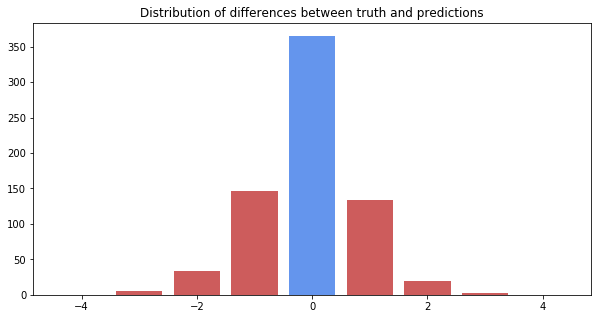

In [423]:
# Display results

d = [y-min(5, max(1, round(ypred))) for y, ypred in zip(Y, Ypred)]
d2 = {i:d.count(i) for i in range(-4, 5)}

plt.figure(figsize = (10, 5))
plt.bar(list(d2.keys()), list(d2.values()), color=['indianred']*4 + ['cornflowerblue'] + ['indianred']*4)
plt.title("Distribution of differences between truth and predictions");

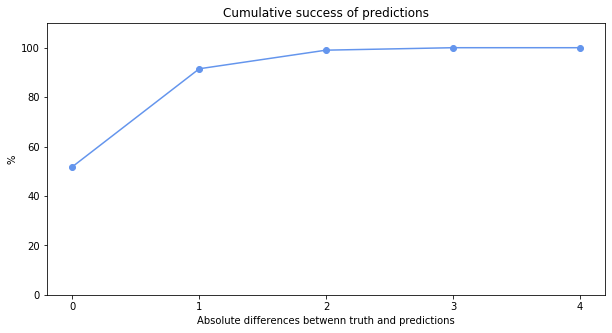

In [424]:
d = [abs(y-min(5, max(1, round(ypred)))) for y, ypred in zip(Y, Ypred)]
d2 = {i:d.count(i) for i in range(5)}
d3 = {i:sum(list(d2.values())[:(i+1)])/sum(list(d2.values()))*100 for i in range(5)}

plt.figure(figsize = (10, 5))
plt.plot(list(d3.keys()), list(d3.values()), 'g-o', color='cornflowerblue')
plt.ylim(0, 110)
plt.ylabel('%')
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel('Absolute differences betwenn truth and predictions')
plt.title("Cumulative success of predictions");

# III - Vizualisation

In [425]:
import json

def highlight(word, attn):
    html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(sentence, attns):
    html = ""
    for word, attn in zip(sentence, attns):
        html += ' ' + highlight(
            word,
            attn
        )
    return html + "<br><br>\n"

def goodscale(lst) :
    m = min(lst)
    M = max(lst)
    return [(x-m)**3/(M-m)**3 for x in lst]

In [426]:
# Import data

with open('yelp_reviews_part1.json') as json_file:
    reviews = json.load(json_file)

print("File imported ({} reviews)".format(len(reviews)))

keys = list(reviews.keys())

File imported (14075 reviews)


In [430]:
### Compute html output

# choose data
reviewKeys = []
k = 0
stars = []
while len(reviewKeys) < 5 :
    star = reviews[keys[k]]['stars']
    if star not in stars and np.random.uniform() < 0.5 : 
        reviewKeys.append(keys[k])
        stars.append(star)
    k += 1

f = open("attn.html", "w") # store file
r = 0
for nr in reviewKeys : 

    # extract data
    text = reviews[nr]['text']
    star = reviews[nr]['stars']

    # prepare text
    wordsList = df['word'].tolist()

    words = re.findall(r"[\w']+", text)
    words = [w.lower().replace("'", " ") for w in words if w in wordsList]
    tmp = df[df['word'].isin(words)]
    vectors = [tmp[tmp['word'] == w].iloc[0,2:].tolist() for w in words]

    x = torch.tensor(vectors).view(1, -1, 128)
    encoder_outputs = encoder(x)
    output, attn = classifier(encoder_outputs)

    # prediction
    starpred = min(max(1, round(float(output))), 5)

    # attentions
    num_heads = attn.size()[2]
    attentions = {i:[float(at[0][i]) for at in attn] for i in range(num_heads)}
    for i in range(num_heads):
        m = min([float(at[0][i]) for at in attn])
        attentions[i] = [float(at[0][i]) for at in attn]
        attentions[i] = goodscale(attentions[i])

    # compute
    wordsLst = []
    wordsAttn = {i:[] for i in range(num_heads)}
    i = 0
    j = 0
    k = 0
    w =  words[k]
    l = len(w)
    while i < len(text):
        wt = text[i:(i+l)]
        if wt.lower().replace("'", " ").replace("\n", "") == w : 
            wordsLst.append(text[j:i])
            wordsLst.append(wt)
            for nh in range(num_heads) :  
                wordsAttn[nh].append(0)
                wordsAttn[nh].append(attentions[nh][k])
            i = i+l
            j = i
            k += 1
            try : 
                w =  words[k]
                l = len(w)
            except : break
        else :
            i += 1

    # Store data
    f.write('<h3><center>Review {} on {}</center></h3> <b>Star prediction : {} - Truth : {} </b><br><br>'.format(r+1, 5, starpred, int(star)))
    r+=1
    for nh in range(num_heads) : 
        f.write('<i>Attention head {} </i><br>'.format(nh+1))
        f.write( mk_html(wordsLst, wordsAttn[nh]))
        
f.close()